In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import Options

import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn.apionly as sns
from tqdm import tqdm_notebook as tqdm

# plt.style.use('clean')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/jiafengchen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
%run sample_prices.py
%run report/scripts/pricecall.py
%run interpolated_local_vol.py

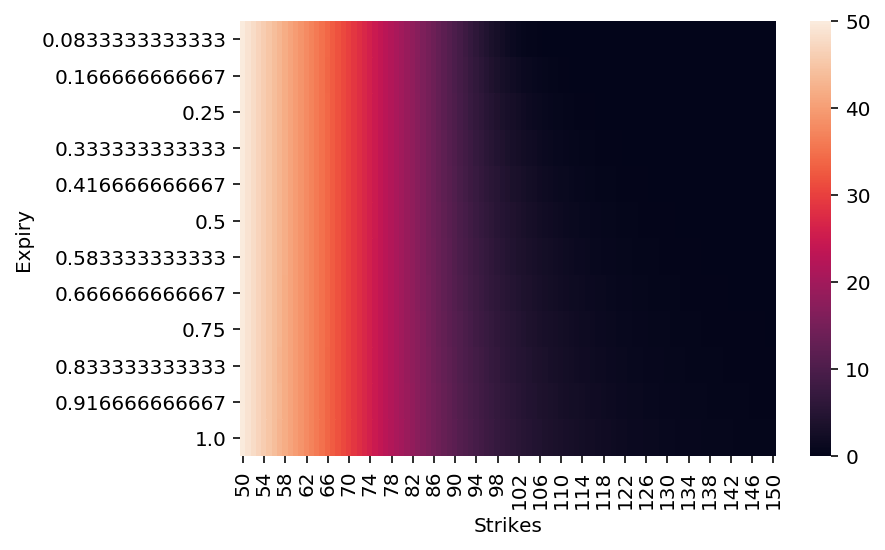

In [3]:
# def quadratic_vol(px, time):
#     return np.clip(.16 + 1e-4*(px-100)**2, 0, .5)

# def quadratic_vol(px, time):
#     """not quadratic"""
#     return 0.2 * (np.cos((px-100)/8)) ** 2 + 0.16

# def quadratic_vol(px, time):
#     return .16 + 1e-4*(px-100)**2

# def quadratic_vol(px,time):
#     """No extrema"""
#     return .24 + .1 / (1+np.exp((px-100)/5))

def quadratic_vol(px, time):
    """No convexity"""
    return np.clip(0.16 + (px - 100)/300,0,1)


expiries = np.arange(1/12,13/12,1/12)
K = np.arange(50,151,1)

samples = sample_end_prices(100, quadratic_vol, expiries, 100, int(5e5))
pxs = price_calls(K, samples)

sns.heatmap(pxs)

In [4]:
def get_fd_local_vol(C_grid, tol=0.):
    dts = np.diff(C_grid.index)
    
    dCdt = np.clip((C_grid.as_matrix()[1:,:] - C_grid.as_matrix()[:-1,:]) / dts[:,np.newaxis], a_min=0, a_max=None)
    dCdt_compatible = (dCdt[1:,1:-1] + dCdt[:-1,1:-1]) / 2
    #assert len(set(np.diff(C_grid.columns))) == 1
    Kdiff = np.diff(C_grid.columns)[0]
    d2CdK2 = (C_grid.as_matrix()[:,:-2] + C_grid.as_matrix()[:,2:] - 2*C_grid.as_matrix()[:,1:-1]) / Kdiff**2
    d2CdK2_compatible = d2CdK2[1:-1,:]
    d2CdK2_compatible[d2CdK2_compatible < tol] = np.nan

    new_expiries = C_grid.index[1:-1]
    new_strikes = np.array(C_grid.columns[1:-1])    
    
    return (pd.DataFrame(dCdt_compatible/(1/2 * np.array(new_strikes ** 2).reshape(1,-1) * d2CdK2_compatible), 
                        index=new_expiries, 
                        columns=new_strikes),
            dCdt_compatible,
            d2CdK2_compatible)
    

In [5]:
local_vol, dCdt, dCdK2  = get_fd_local_vol(pxs, tol=0.001)
local_vol = np.sqrt(local_vol)

In [6]:
means = local_vol.iloc[:,:].mean().dropna()
meaned_vol = pd.DataFrame({0: means, 1000: means}).transpose()

In [7]:
f = InterpolatedLocalVol(meaned_vol.as_matrix().T, 
                         meaned_vol.columns, meaned_vol.index)

In [8]:
f_nn = NNLocalVol(meaned_vol.as_matrix().T, 
                         meaned_vol.columns, meaned_vol.index)

(80, 120)

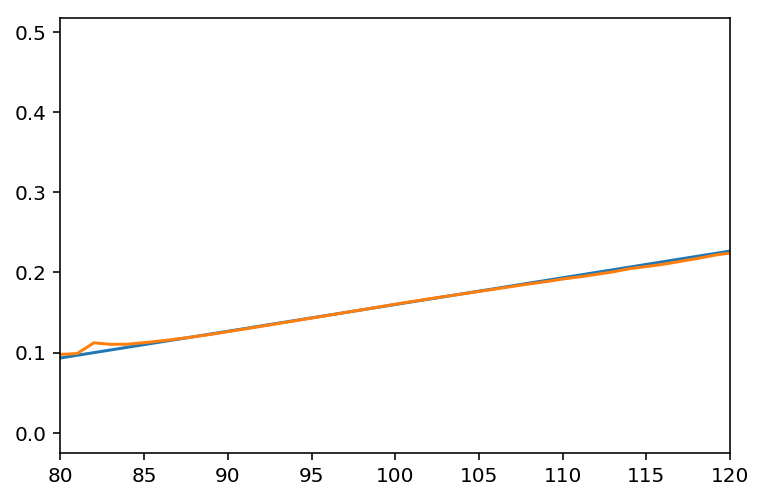

In [9]:
xs = np.arange(20,200,.1)
# plt.plot(xs,f(xs,2))
plt.plot(xs, quadratic_vol(xs,2))
plt.plot(xs,f(xs,2))
plt.xlim((80,120))

(-0.002, 0.001)

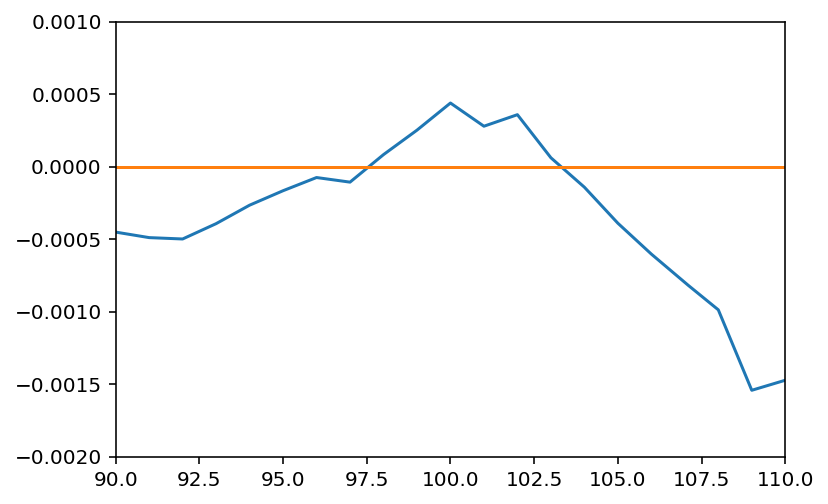

In [21]:
xs = np.arange(20,200,.1)
# plt.plot(xs,f(xs,2))
plt.plot(xs, f(xs,2).flatten() - quadratic_vol(xs,2))
plt.plot([80,120],[0,0])
plt.xlim((90,110))
plt.ylim((-0.002,0.001))

In [122]:
logit(3)

nan

In [11]:
%time f_samples = sample_end_prices(100, f, np.arange(1/12,1,1/12), 100, int(1e5))

CPU times: user 1.23 s, sys: 46.1 ms, total: 1.27 s
Wall time: 1.28 s


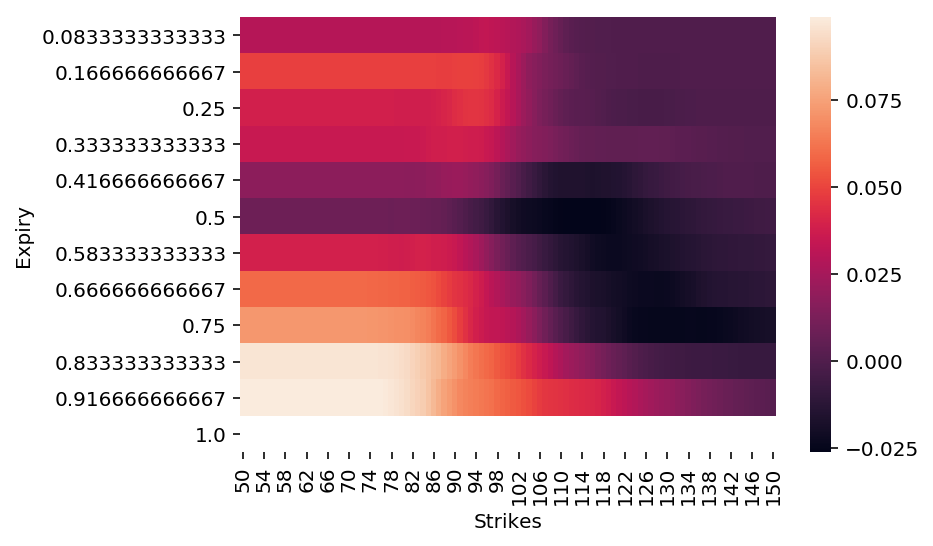

In [23]:
# def noise(px, time):
#     p = (np.abs(px - 100) < 10).astype(float)
#     return (1-p) * quadratic_vol(px, time) + p * f(px, time).flatten()

def noise(px, time):
    return quadratic_vol(px, time) + .0005

sns.heatmap(price_calls(K, sample_end_prices(100, noise, np.arange(1/12,1,1/12), 100, int(1e5))) - pxs)

In [124]:
f_pxs = price_calls(K, f_samples)

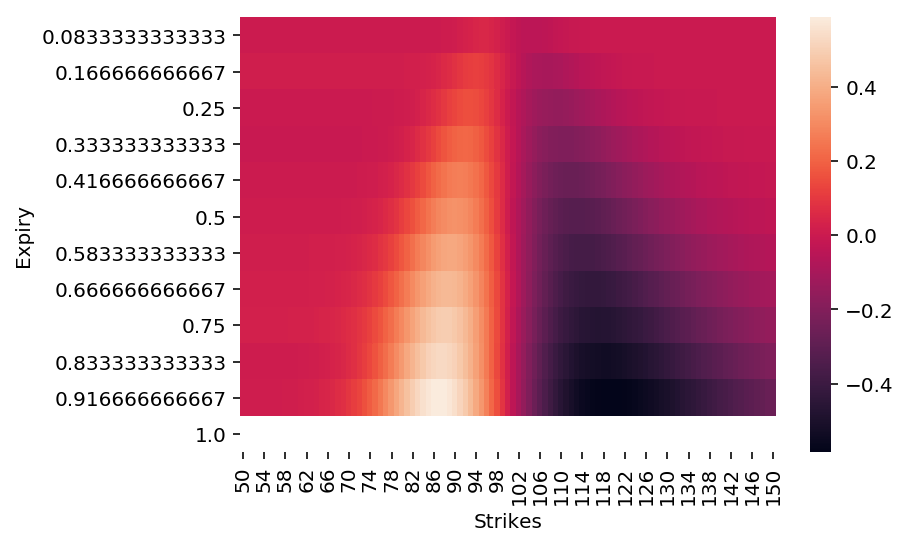

In [125]:
sns.heatmap((f_pxs - pxs))

In [150]:
pxs.loc[:,70:100]

Strikes,70,71,72,73,74,75,76,77,78,79,...,91,92,93,94,95,96,97,98,99,100
Expiry,,,,,,,,,,,,,,,,,,,,,
0.083333,29.994641,28.994644,27.994650,26.994659,25.994675,24.994706,23.994754,22.994834,21.994969,20.995213,...,9.482151,8.687471,7.935937,7.226373,6.556567,5.924271,5.327488,4.764083,4.232918,3.733153
0.166667,29.992643,28.993215,27.994019,26.995104,25.996542,24.998441,24.000956,23.004340,22.008891,21.015021,...,10.120145,9.425769,8.767868,8.142173,7.544757,6.972457,6.423097,5.895050,5.386902,4.897816
0.250000,30.012440,29.016469,28.021476,27.027631,26.035134,25.044225,24.055235,23.068607,22.084826,21.104690,...,10.683886,10.037331,9.421585,8.832332,8.265788,7.719142,7.190310,6.677706,6.180231,5.697223
0.333333,30.032670,29.043886,28.057179,27.072758,26.090799,25.111662,24.135630,23.163186,22.195102,21.232275,...,11.171651,10.553248,9.962186,9.394377,8.846389,8.315461,7.799587,7.297469,6.808045,6.330640
0.416667,30.070960,29.092357,28.116764,27.144275,26.175137,25.209583,24.248114,23.291238,22.339729,21.394541,...,11.613123,11.013283,10.438865,9.885400,9.349761,8.829726,8.323352,7.829297,7.346601,6.874571
0.500000,30.122761,29.155464,28.191868,27.232185,26.276630,25.325430,24.378964,23.437652,22.502354,21.574102,...,12.020335,11.434372,10.872291,10.330172,9.804844,9.293861,8.795323,8.307911,7.830792,7.363550
0.583333,30.190916,29.235719,28.284886,27.338525,26.396732,25.459784,24.527968,23.601909,22.682390,21.770246,...,12.411241,11.836084,11.283567,10.749859,10.231984,9.727404,9.234359,8.751804,8.279066,7.815621
0.666667,30.279900,29.337325,28.399570,27.466636,26.538688,25.615849,24.698457,23.787024,22.882280,21.985215,...,12.793829,12.227161,11.682255,11.155353,10.643468,10.144414,9.656394,9.178334,8.709524,8.249404
0.750000,30.363796,29.433682,28.508797,27.589067,26.674522,25.765308,24.861665,23.964193,23.073608,22.190761,...,13.151182,12.592336,12.054315,11.533342,11.026623,10.532103,10.048168,9.573848,9.108534,8.651625


In [62]:
%time actual_samples = sample_end_prices(100, quadratic_vol,\
                                         np.arange(1/12,1,1/12), 100, int(1e5))

CPU times: user 85.1 ms, sys: 6.02 ms, total: 91.1 ms
Wall time: 91.2 ms


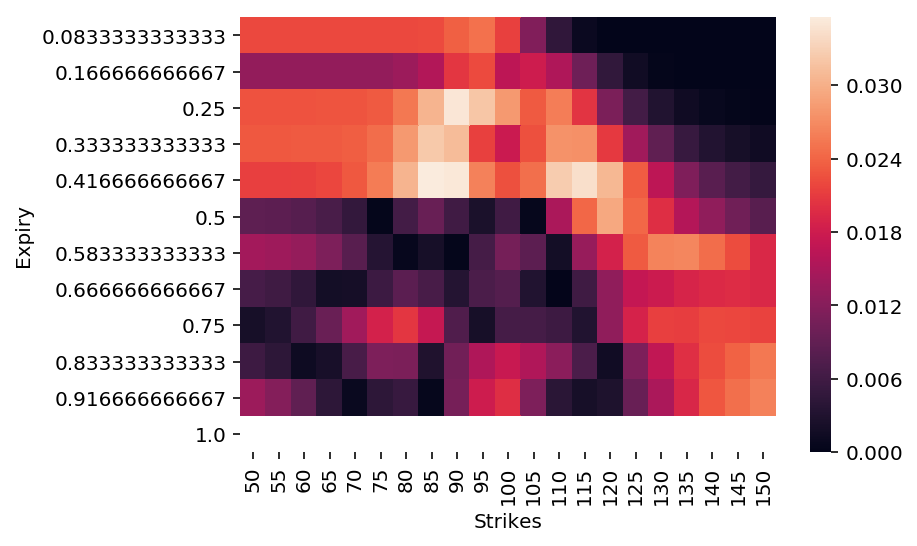

In [63]:
sns.heatmap(np.abs(price_calls(K,actual_samples) - pxs))